In [ ]:
# default_exp cryptotree

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

# cryptotree

> Homomorphic implementations of neural decisions trees.

## Homomorphic trees

In [ ]:
# export
from cryptotree.seal_helper import *
from cryptotree.polynomials import polyeval_tree
from cryptotree.linear import arrays_to_ptx, extract_diagonals, matrix_multiply_diagonals, pad_along_axis

from seal import *

import numpy as np
import torch
from typing import List, Callable

In [ ]:
# export
def to_list_and_duplicate(array):
    """Takes an array, append a 0 then copies itself once more.

    This step is necessary to do matrix multiplication with Galois rotations.
    """
    array = list(array)
    array = array + [0] + array
    return array

def to_list_and_pad(array):
    """Takes an array, append a 0 then copies itself once more.

    This step is necessary to do matrix multiplication with Galois rotations.
    """
    array = list(array)
    array = array + [0] * (len(array) - 1)
    return array

In [ ]:
# export
from cryptotree.tree import NeuralDecisionTree

class HomomorphicModel:
    """Base class for Homormorphic Decision Trees and Random Forest. 
    
    As the Homomorphic Evaluator will only need weights, and comparator 
    for the Homomorphic Featurizer, a model should only return these two. 
    """
    def return_weights(self):
        return self.b0, self.w1, self.b1, self.w2, self.b2
    
    def return_comparator(self) -> np.ndarray:
        """Returns the comparator, which is a numpy array of the comparator,
        with -1 indices for null values. The array is repeated for Galois
        rotations before the multiplication."""
        
        comparator = list(self.comparator)
        comparator = comparator + [-1] + comparator
        comparator = np.array(comparator)
        return comparator

class HomomorphicDecisionTree(HomomorphicModel):
    """Homomorphic Decision Tree, which extracts appropriate weights for
    homomorphic operations from a Neural Decision Tree."""
    
    def __init__(self, tree: NeuralDecisionTree):
        matcher = tree.matcher
        head = tree.head
        
        # We first get the comparator and set to -1 the rows that were padded
        comparator = tree.comparator.weight.data.numpy()
        padded_rows = (comparator.sum(axis=1) == 0)
        
        # We then get the indices of non padded rows
        comparator = comparator.argmax(axis=1)
        comparator[padded_rows] = -1
        self.comparator = comparator
        
        self.n_leaves = matcher.weight.data.shape[0]
        
        # We add a 0 then copy the initial 
        b0 = tree.comparator.bias.data.numpy()
        self.b0 = to_list_and_duplicate(b0)
        
        # For weights, we first pad the columns, then extract the diagonals, and pad them
        w1 = matcher.weight.data.numpy()
        w1 = pad_along_axis(w1, w1.shape[0], axis=1)
        w1 = extract_diagonals(w1)
        self.w1 = [to_list_and_pad(w1[i]) for i in range(len(w1))]
        
        b1 = matcher.bias.data.numpy()
        self.b1 = to_list_and_pad(b1)
        
        w2 = head.weight.data.numpy()
        self.w2 = [to_list_and_pad(w2[c]) for c in range(len(w2))]
        
        b2 = head.bias.data.numpy()
        self.b2 = [to_list_and_pad(([b2[c] / self.n_leaves]) * self.n_leaves) for c in range(len(b2))]

In [ ]:
# export
from cryptotree.tree import NeuralRandomForest

class HomomorphicNeuralRandomForest(HomomorphicModel):
    """"""
    def __init__(self, neural_rf: NeuralRandomForest):
        
        homomorphic_trees = [HomomorphicDecisionTree(neural_tree) for neural_tree in neural_rf.neural_trees]

        B0, W1, B1, W2, B2 = [], [], [], [], []
        comparator = []

        for h in homomorphic_trees:
            b0, w1, b1, w2, b2 = h.return_weights()
            B0 += b0
            W1.append(w1)
            B1 += b1
            W2.append(w2)
            B2.append(b2)
            comparator += list(h.return_comparator())

        self.comparator = comparator

        W1 = list(np.concatenate(W1, axis=-1))
        W2 = list(np.concatenate(W2, axis=-1))
        B2 = list(np.concatenate(B2, axis=-1))
        
        # We will multiply each class vector with the corresponding weight for each tree
        weights = neural_rf.weights
        block_size = neural_rf.n_leaves_max * 2 - 1
        weights = [[weight.item()] * block_size for weight in weights]
        weights = np.concatenate(weights)
        
        W2 = [w2 * weights for w2 in W2]
        B2 = [b2 * weights for b2 in B2]
        
        self.b0 = B0
        self.w1 = W1
        self.b1 = B1
        self.w2 = W2
        self.b2 = B2

## Homomorphic evaluator and featurizer

Now to evaluate our models, we will use an evaluator, which is a general purpose class which will do the computing based on the provided weights.

In [ ]:
# export
from typing import List
from functools import partial
from cryptotree.tree import NeuralDecisionTree

class HomomorphicTreeEvaluator:
    """Evaluator which will perform homomorphic computation"""
    
    def __init__(self, b0: np.ndarray, w1, b1, w2, b2,
                 activation_coeffs: List[float], polynomial_evaluator: Callable,
                 evaluator: Evaluator, encoder: CKKSEncoder,
                 relin_keys: RelinKeys, galois_keys: GaloisKeys, scale: float):
        """Initializes with the weights used during computation.
        
        Args:
            b0: bias of the comparison step
        
        """
        self.slot_count = encoder.slot_count()
        
        self.evaluator = evaluator
        self.encoder = encoder
        self.relin_keys = relin_keys
        self.galois_keys = galois_keys
        self.scale = scale
        
        self.activation = partial(polynomial_evaluator, coeffs=activation_coeffs,
                                            evaluator=evaluator, encoder=encoder, 
                                            relin_keys=relin_keys, scale=scale)
        
        self.b0_ptx = self.to_ptx(b0)
        self.w1_ptx = [self.to_ptx(w) for w in w1]
        self.b1_ptx = self.to_ptx(b1)
        self.w2_ptx = [self.to_ptx(w) for w in w2]
        self.b2_ptx = [self.to_ptx(b) for b in b2]
        
    def __call__(self, ctx: Ciphertext):
        
        # First we add the first bias to do the comparisons
        ctx = self.compare(ctx)
        ctx = self.match(ctx)
        outputs = self.decide(ctx)
        
        return outputs
    
    def compare(self, ctx: Ciphertext) -> Ciphertext:
        """Applies comparisons homomorphically.
        
        It first adds the thresholds, then compute the activation.
        """
        output = Ciphertext()
        evaluator.add_plain(ctx, self.b0_ptx, output)
        output = self.activation(output)
        return output
    
    def match(self, ctx: Ciphertext) -> Ciphertext:
        """Applies matching homomorphically.
        
        First it does the matrix multiplication with diagonals, then activate it.
        """
        output = matrix_multiply_diagonals(self.w1_ptx, ctx, self.evaluator, self.galois_keys)

        self.evaluator.mod_switch_to_inplace(self.b1_ptx, output.parms_id())
        output.scale(self.scale)
        self.evaluator.add_plain_inplace(output, self.b1_ptx)
        
        output = self.activation(output)
        return output
    
    def decide(self, ctx: Ciphertext):
        """Applies the decisions homomorphically.
        
        For each class, multiply the ciphertext with the corresponding weight of that class and
        add the bias afterwards.
        """
        outputs = []
        for w_ptx,b_ptx in zip(self.w2_ptx, self.b2_ptx):
            output = Ciphertext()

            self.evaluator.mod_switch_to_inplace(w_ptx, ctx.parms_id())

            self.evaluator.multiply_plain(ctx, w_ptx, output)
            self.evaluator.rescale_to_next_inplace(output)

            evaluator.mod_switch_to_inplace(b_ptx, output.parms_id())
            output.scale(scale)

            evaluator.add_plain_inplace(output, b_ptx)
            outputs.append(output)
        return outputs
        
    def to_ptx(self, array):
        """Pads an array and convert it to a plaintext"""
        array = DoubleVector(list(array))
        
        ptx = Plaintext()
        self.encoder.encode(array, self.scale, ptx)
        return ptx
    
    @classmethod
    def from_model(cls, model: HomomorphicModel, 
                  activation_coeffs: List[float], polynomial_evaluator: Callable,
                  evaluator: Evaluator, encoder: CKKSEncoder,
                  relin_keys: RelinKeys, galois_keys: GaloisKeys, scale: float):
        """Creates an Homomorphic Tree Evaluator from a model, i.e a neural tree or
        a neural random forest. """
        b0, w1, b1, w2, b2 = model.return_weights()
        
        return cls(b0, w1, b1, w2, b2, activation_coeffs, polynomial_evaluator,
                   evaluator, encoder, relin_keys, galois_keys, scale)

In [ ]:
# export
class HomomorphicTreeFeaturizer:
    """Featurizer used by the client to encode and encrypt data."""
    def __init__(self, comparator: np.ndarray, 
                 encoder: CKKSEncoder, encryptor: Encryptor, scale: float):
        self.comparator = comparator
        self.encryptor = encryptor
        self.encoder = encoder
        self.scale = scale
        
    def encrypt(self, x: np.ndarray):
        features = x[self.comparator]
        features[self.comparator == -1] = 0
        features = DoubleVector(list(features))
        
        ptx = Plaintext()
        encoder.encode(features, scale, ptx)
        
        ctx = Ciphertext()
        encryptor.encrypt(ptx, ctx)
        return ctx

## Example

Here we will see an example of Homomorphic trees in action.

First we can have a look at the activation that will be used, which is a polynomial approximation of the sigmoid with a dilatation factor of 16.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2d33ee1610>)

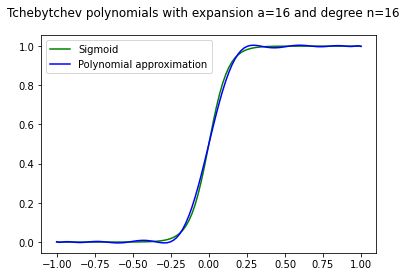

In [ ]:
from cryptotree.polynomials import (chebyshev_approximation, polynomial_approximation_coefficients, 
plot_graph_function_approximation)
import torch

dilatation_factor = 16
degree = dilatation_factor

p,_ = chebyshev_approximation(torch.sigmoid, dilatation_factor=dilatation_factor,
                                              polynomial_degree=degree)
coeffs = polynomial_approximation_coefficients(torch.sigmoid, dilatation_factor=dilatation_factor,
                                              polynomial_degree=degree)
plot_graph_function_approximation(torch.sigmoid, dilatation_factor=dilatation_factor,
                                              polynomial_degree=degree)

In [ ]:
np.log2(np.abs(coeffs.max()))

9.728525111322655

In [ ]:
import numpy as np 

PRECISION_BITS = 30
UPPER_BITS = 5

polynomial_multiplications = int(np.ceil(np.log2(degree))) + 1
n_polynomials = 2
matrix_multiplications = 2

depth = matrix_multiplications + polynomial_multiplications * n_polynomials

poly_modulus_degree = 16384 * 2

moduli = [PRECISION_BITS + UPPER_BITS] + (depth) * [PRECISION_BITS] + [PRECISION_BITS + UPPER_BITS]
print(moduli)
print(sum(moduli))

[35, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 35]
430


Now we will populate our SEAL environment with a helper function using the parameters we have defined. Using the builtins, we will be able to call *print_ctx* without having to provide the encoder and decryptor.

In [ ]:
from cryptotree.seal_helper import create_seal_globals, append_globals_to_builtins
import builtins

create_seal_globals(globals(), poly_modulus_degree, moduli, PRECISION_BITS)
append_globals_to_builtins(globals(), builtins)

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train = scaler.fit_transform(X_train)

rf = RandomForestClassifier(max_depth=4, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
n_nodes = tree.tree_.node_count
children_left = tree.tree_.children_left
children_right = tree.tree_.children_right
feature = tree.tree_.feature
threshold = tree.tree_.threshold

# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True
        
print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 13 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 3] <= 0.2916666641831398 else to node 2.
	node=1 leaf node.
	node=2 test node: go to node 3 if X[:, 2] <= 0.6637930870056152 else to node 8.
		node=3 test node: go to node 4 if X[:, 3] <= 0.6458333432674408 else to node 5.
			node=4 leaf node.
			node=5 test node: go to node 6 if X[:, 1] <= 0.4583333283662796 else to node 7.
				node=6 leaf node.
				node=7 leaf node.
		node=8 test node: go to node 9 if X[:, 3] <= 0.6875 else to node 12.
			node=9 test node: go to node 10 if X[:, 3] <= 0.6458333432674408 else to node 11.
				node=10 leaf node.
				node=11 leaf node.
			node=12 leaf node.



In [ ]:
from cryptotree.tree import SigmoidTreeMaker

tree_maker = SigmoidTreeMaker(dilatation_factor=dilatation_factor, polynomial_degree=degree, 
                              use_polynomial=True)

neural_tree = tree_maker.make_tree(tree)
htree = HomomorphicDecisionTree(neural_tree)

tree_evaluator = HomomorphicTreeEvaluator.from_model(htree, tree_maker.coeffs, 
                                                   polyeval_tree, evaluator, encoder, relin_keys, galois_keys, 
                                                   scale)

featurizer = HomomorphicTreeFeaturizer(htree.return_comparator(), encoder, encryptor, scale)

x = X_train[0]
ctx = featurizer.encrypt(x)

outputs = tree_evaluator(ctx)

for output in outputs:
    ptx = Plaintext()
    decryptor.decrypt(output, ptx)
    
    values = DoubleVector()
    encoder.decode(ptx, values)
    
    output = sum(list(values))
    print(output)

0.08981352184491735
0.6723222702858054
0.03394028177717689


In [ ]:
neural_tree(torch.tensor(x).float())

tensor([0.0915, 0.6718, 0.0358], grad_fn=<AddBackward0>)

In [ ]:
from cryptotree.tree import NeuralRandomForest

tree_maker = SigmoidTreeMaker(dilatation_factor=dilatation_factor, polynomial_degree=degree, use_polynomial=True)

neural_rf = NeuralRandomForest(rf.estimators_, tree_maker)

In [ ]:
x = X_train[0]
x = torch.tensor(x).float()
x = x.unsqueeze(0)

In [ ]:
neural_rf(x)

In [ ]:
h_rf = HomomorphicNeuralRandomForest(neural_rf)

tree_evaluator = HomomorphicTreeEvaluator.from_model(h_rf, tree_maker.coeffs, 
                                                   polyeval_tree, evaluator, encoder, relin_keys, galois_keys, 
                                                   scale)

featurizer = HomomorphicTreeFeaturizer(h_rf.return_comparator(), encoder, encryptor, scale)

x = X_train[0]
ctx = featurizer.encrypt(x)

outputs = tree_evaluator(ctx)

for output in outputs:
    ptx = Plaintext()
    decryptor.decrypt(output, ptx)
    
    values = DoubleVector()
    encoder.decode(ptx, values)
    
    output = sum(list(values))
    print(output)

In [ ]:
x = np.arange(16)
ctx = featurizer.encrypt(x)

In [ ]:
print_range_ctx(ctx, 8)

0 : 3.0000016404868814
1 : 1.9999958839850382
2 : 2.9999994127167877
3 : 1.0000004244528027
4 : -1.14699563824594e-06
5 : 2.000002310047675
6 : 3.1227868845413394e-06
7 : 8.855974365899294e-06


In [ ]:
neural_trees = neural_rf.neural_trees[:2]
homomorphic_trees = [HomomorphicDecisionTree(tree) for tree in neural_trees]

B0, W1, B1, W2, B2 = [], [], [], [], []
comparator = []

for h in homomorphic_trees:
    b0, w1, b1, w2, b2 = h.return_weights()
    B0 += b0
    W1.append(w1)
    B1 += b1
    W2.append(w2)
    B2.append(b2)
    comparator += list(h.return_comparator())
    
comparator = np.array(comparator)

W1 = list(np.concatenate(W1, axis=-1))
W2 = list(np.concatenate(W2, axis=-1))
B2 = list(np.concatenate(B2, axis=-1))

In [ ]:
np.array(W2).shape

(3, 42)

In [ ]:
# export
from fastcore.test import test_close

def test_ciphertext(ctx_target: Ciphertext, ctxs: List[Ciphertext], distance: int):
    """Tests if the ctx target is equal to the other ciphertexts when shifted by the distance"""
    
    output = Ciphertext()
    temp = Ciphertext()
    
    for i,ctx in enumerate(ctxs):
        shift = -(i * distance)
        evaluator.rotate_vector(ctx, shift, galois_keys, temp)
        if i == 0:
            evaluator.sub(ctx_target, temp, output)
        else:
            evaluator.sub_inplace(output, temp)
    values = DoubleVector()
    ptx = Plaintext()
    
    decryptor.decrypt(output, ptx)
    encoder.decode(ptx, values)
    return test_close(np.abs(np.mean(values)), 0)

In [ ]:
x = X_train[0]

distance = len(comparator) // len(neural_trees)

# We create the different featurizer
featurizer = HomomorphicTreeFeaturizer(comparator, encoder, encryptor, scale)
f1 = HomomorphicTreeFeaturizer(htree1.return_comparator(), encoder, encryptor, scale)
f2 = HomomorphicTreeFeaturizer(htree2.return_comparator(), encoder, encryptor, scale)

ctx = featurizer.encrypt(x)
ctx1 = f1.encrypt(x)
ctx2 = f2.encrypt(x)

test_ciphertext(ctx, [ctx1, ctx2], distance)

In [ ]:
B0_ptx = to_ptx(B0)

In [ ]:
output = Ciphertext()
evaluator.add_plain(ctx, B0_ptx, output)

In [ ]:
b01 = to_ptx(htree1.b0)
b02 = to_ptx(htree2.b0)

output1 = Ciphertext()
output2 = Ciphertext()

evaluator.add_plain(ctx1, b01, output1)
evaluator.add_plain(ctx2, b02, output2)

In [ ]:
test_ciphertext(output, [output1, output2], distance)

In [ ]:
def to_ptx(values):
    ptx = Plaintext()
    encoder.encode(DoubleVector(list(values)), scale, ptx)
    return ptx

In [ ]:
output = Ciphertext()
evaluator.add_plain(ctx, )

True

In [ ]:


output = Ciphertext()
evaluator.sub(ctx, ctx1, temp)
evaluator.rotate_vector(ctx2, -shift, galois_keys)
evaluator.sub_inplace(temp, ctx2)

In [ ]:
from fastcore.test import is_close, test_eq

In [ ]:
values = DoubleVector()
ptx = Plaintext()
decryptor.decrypt(temp, ptx)
encoder.decode(ptx, values)

is_close(np.abs(np.mean(values)), 0)

True

In [ ]:
evaluator.rotate_vector_inplace(ctx2, -21, galois_keys)

In [ ]:
from cryptotree.tree import NeuralRandomForest

tree_maker = SigmoidTreeMaker(dilatation_factor=dilatation_factor, polynomial_degree=degree, use_polynomial=True)

neural_rf = NeuralRandomForest(rf.estimators_, tree_maker)

In [ ]:
htree = HomomorphicDecisionTree(neural_rf.neural_trees[0])
tree_evaluator = HomomorphicTreeEvaluator.from_tree(neural_rf.neural_trees[0], 
                                                    tree_maker.coeffs, polyeval_tree, 
                                                    evaluator, encoder, relin_keys, galois_keys, scale)
featurizer = HomomorphicTreeFeaturizer(htree.return_comparator(), encoder, encryptor, scale)

i = 0
x = X_train[i]

ctx = featurizer.encrypt(X_train[i])

In [ ]:
comparator = return_comparator(htrees)
featurizer = HomomorphicTreeFeaturizer(comparator, encoder, encryptor, scale)

i = 0
x = X_train[i]

ctx = featurizer.encrypt(X_train[i])

NameError: name 'return_comparator' is not defined

In [ ]:
outputs = tree_evaluator(ctx)

for output in outputs:
    ptx = Plaintext()
    decryptor.decrypt(output, ptx)
    
    values = DoubleVector()
    encoder.decode(ptx, values)
    
    output = sum(list(values))
    print(output)
    
with torch.no_grad():
    x = X_train[i]
    expected_output = tree.comparator(torch.tensor(x).float())
    expected_activation = tree.activation(expected_output)
    expected_z1 = tree.matcher(expected_activation)
    expected_activation1 = tree.activation(expected_z1)

tree.head(expected_activation1)

RuntimeError: result ciphertext is transparent

In [ ]:
activation = tree_evaluator.compare(ctx)

with torch.no_grad():
    x = X_train[i]
    expected_output = tree.comparator(torch.tensor(x).float())
    expected_activation = tree.activation(expected_output)

def print_comparison(expected_output: torch.tensor, output: Ciphertext):
    for i, value in enumerate(expected_output.view(-1,1)):
        print(f"Expected value : {value.item()}, real value : {ctx_value(output,i)}")
        
print_comparison(expected_activation,activation)

Expected value : 1.003414273262024, real value : 1.003414339758932
Expected value : 0.17561917006969452, real value : 0.17561912736812443
Expected value : 0.2473641335964203, real value : 0.2473641970353432
Expected value : 0.3680550754070282, real value : 0.368055114730459
Expected value : 0.038348451256752014, real value : 0.038348424935052416
Expected value : 0.06468749046325684, real value : 0.06468743037114652


In [ ]:
expected_z1 = tree.matcher(expected_activation)
expected_activation1 = tree.activation(expected_z1)

activation1 = tree_evaluator.match(activation)
print_comparison(expected_activation1, activation1)

Expected value : 0.24583998322486877, real value : 0.24583996976655587
Expected value : 0.5430112481117249, real value : 0.543011231603536
Expected value : 0.13242687284946442, real value : 0.1324269443717729
Expected value : 0.05972161889076233, real value : 0.059721653811459496
Expected value : 0.3132869303226471, real value : 0.31328694712229244
Expected value : 0.013727903366088867, real value : 0.013727909255017323
Expected value : 0.0042535364627838135, real value : 0.0042535198961835


In [ ]:
activation = tree_evaluator.compare(ctx)
print_comparison(expected_activation, activation)
activation1 = tree_evaluator.match(activation)
print_comparison(expected_activation1, activation1)
outputs = tree_evaluator.decide(activation1)

for output in outputs:
    ptx = Plaintext()
    decryptor.decrypt(output, ptx)
    
    values = DoubleVector()
    encoder.decode(ptx, values)
    
    output = sum(list(values))
    print(output)
    
tree.head(expected_activation1)

Expected value : 1.003414273262024, real value : 1.0034143492655687
Expected value : 0.17561917006969452, real value : 0.17561913080749808
Expected value : 0.2473641335964203, real value : 0.24736420766782413
Expected value : 0.3680550754070282, real value : 0.3680551012469389
Expected value : 0.038348451256752014, real value : 0.038348434757127986
Expected value : 0.06468749046325684, real value : 0.06468745118821684
Expected value : 0.24583998322486877, real value : 0.24583996976655587
Expected value : 0.5430112481117249, real value : 0.543011231603536
Expected value : 0.13242687284946442, real value : 0.1324269443717729
Expected value : 0.05972161889076233, real value : 0.059721653811459496
Expected value : 0.3132869303226471, real value : 0.31328694712229244
Expected value : 0.013727903366088867, real value : 0.013727909255017323
Expected value : 0.0042535364627838135, real value : 0.0042535198961835
-0.06642822816502385
0.1774497263832028
-0.09325138102576604


tensor([-0.0664,  0.1774, -0.0933], grad_fn=<AddBackward0>)

In [ ]:
activation = tree_evaluator.compare(ctx)
activation1 = tree_evaluator.match(activation)
outputs = tree_evaluator.decide(activation1)

for output in outputs:
    ptx = Plaintext()
    decryptor.decrypt(output, ptx)
    
    values = DoubleVector()
    encoder.decode(ptx, values)
    
    output = sum(list(values))
    print(output)

0.32487582422618266
0.272924422199138
-0.13027203940146034


In [ ]:
for output in outputs:
    ptx = Plaintext()
    decryptor.decrypt(output, ptx)
    
    values = DoubleVector()
    encoder.decode(ptx, values)
    
    output = sum(list(values))
    print(output)

0.03729203950206293
0.24896383547456827
-0.15045334061142052


In [ ]:
ctx.size()

2